# Tutorial file for the r-place-emergence package

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rplacem.canvas_part as rp
import rplacem.thermo as th
import pickle
import os
import seaborn as sns

### Choose an index from the atlas.json file to identify a composition of interest

The r/place [atlas](https://place-atlas.stefanocoding.me/about)
"is an atlas aiming to chart all the artworks created during the r/place April Fools event on Reddit in 2022. It is made with information to each artwork of the canvas provided by the community. The original code was developed by Roland Rytz and is available under the free AGPL license on GitHub. The currently maintained version of the website is managed by Stefano Haagmans and is obtainable under the same license within a [GitHub fork](https://github.com/placeAtlas/atlas). Initial images are provided by Alex Tsernoh."

Each "artwork" or as we call it here, "composition", is indexed according to a string of numbers, found in the atlas.json file. Here, we choose one arbitrarily for demonstration

In [2]:
atlas_id_index = '000006' 

### Load all the pixel data from the npz file

Next, we load all the pixel change data from the npz file. This npz file is a condensed, time-sorted version of the 79 data files provided by reddit from the 2022 r/place experiment. The get_all_pixel_changes() function loads this data and places it into a pandas dataframe

In [3]:
pixel_changes_all = rp.get_all_pixel_changes()

Print the columns of the pixel_changes_all dataframe for reference

In [4]:
pixel_changes_all.columns

Index(['seconds', 'x_coord', 'y_coord', 'user_index', 'color_index',
       'moderator_event'],
      dtype='object')

### Define two types of CanvasPart objects

The CanvasPart class is a superclass with subclasses CanvasComposition and CanvasArea. You can think of a CanvasPart as a part of the canvas defined by a spatial border, which can be either defined by the edge of a particular artwork composition as defined by the r/place Atlas or it can be defined by an arbitrary user-defined border path, which can take any shape. The maximum size of a user-defined border is the size of the canvas itself. 

##### Define a CanvasCompsition object

To define a CanvasComposition object, you must supply the atlas composition id index and the pixel change data loaded from the npz file. The constructor then finds and sets the border path, the x and y coordinates inside the border, and the pixel changes within the border of the composition. 

In [5]:
canvas_comp = rp.CanvasComposition(atlas_id_index)
#rp.check_time('rp.CanvasComposition(atlas_id_index, pixel_changes_all)')

In [6]:
print('Canvas composition pixel changes: \n' + str(canvas_comp.pixel_changes) + '\n \n')
print('Canvas composition border path: \n' + str(canvas_comp.border_path) + '\n \n')
print('Canvas composition x coordinates: \n' + str(canvas_comp.x_coords) + '\n \n')
print('Canvas composition y coordinates: \n' + str(canvas_comp.y_coords) + '\n \n')

Canvas composition pixel changes: 
           seconds  x_coord  y_coord   user_id  color_id
0         1219.603      911      421   2367073         5
1         1226.869      912      421   1159668        16
2         1231.680      913      421   3054718        16
3         1233.864      911      422   2701904         5
4         1239.272      911      425   2710114         5
...            ...      ...      ...       ...       ...
124981  300505.608      911      470   6331348        31
124982  300510.618      936      454   1108705        31
124983  300511.144      950      422  10380382        31
124984  300553.777      949      427    521579        31
124985  300558.739      935      474   8959978        31

[124986 rows x 5 columns]
 

Canvas composition border path: 
[[913 421]
 [909 482]
 [959 480]
 [958 421]]
 

Canvas composition x coordinates: 
[913 914 915 ... 919 920 921]
 

Canvas composition y coordinates: 
[421 421 421 ... 482 482 482]
 



##### Define a CanvasArea object
To define a CanvasArea object, you must supply the border path and the pixel changes from the npz file. 
The border path is a numpy array of x,y points that form the path of the border of the canvas

In [7]:
border_path = np.array([[0,0],[0,5],[5,5],[5,0]])

#rp.check_time('rp.CanvasArea(border_path, pixel_changes_all)')
canvas_area = rp.CanvasArea(border_path, pixel_changes_all=pixel_changes_all)

In [8]:
print('Canvas area pixel changes: \n' + str(canvas_area.pixel_changes) + '\n \n')
print('Canvas area border path: \n' + str(canvas_area.border_path) + '\n \n')
print('Canvas area x coordinates: \n' + str(canvas_area.x_coords)+ '\n \n')
print('Canvas area y coordinates: \n' + str(canvas_area.y_coords)+ '\n \n')

Canvas area pixel changes: 
           seconds  x_coord  y_coord  user_id  color_id
0           21.703        2        2  4068948        22
1          169.534        0        0  4068955        27
2          490.058        1        1  4068959        25
3         1181.441        1        3  1700572        10
4         1184.738        0        0  1644551        25
...            ...      ...      ...      ...       ...
174310  300588.756        0        0  7913751        31
174311  300588.987        0        0   227097        31
174312  300589.027        0        0  1256236        31
174313  300589.360        0        1   364556        31
174314  300589.387        0        0  1295679        31

[174315 rows x 5 columns]
 

Canvas area border path: 
[[0 0]
 [0 5]
 [5 5]
 [5 0]]
 

Canvas area x coordinates: 
[0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5]
 

Canvas area y coordinates: 
[0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 5 5 5 5 5 5]
 



### Get the pixel changes over time, plot, and save a movie of the frames

Now, we can start to examine how the two CanvasPart objects change over time. 
Lets' choose a time step interval of 900 seconds (15 minutes), and a total time 
of 20 hours (20*3600 seconds).

In [9]:
time_interval= 900 #seconds
total_time = 10*3600 #seconds

First, let's plot the canvas_comp object for the specified time steps. You'll notice the plotting function returns a list of indices that allow us to quickly select the pixel change data at different time points inside the boundary. The time_inds_list_comp will come in handy for time-step calculations later on. 

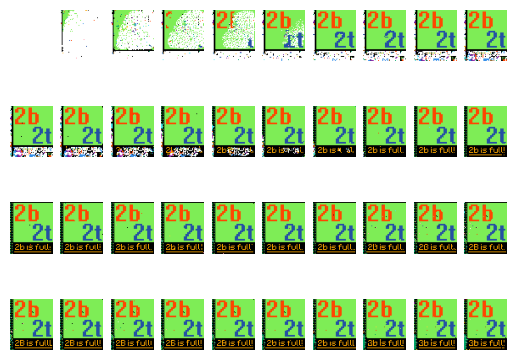

In [10]:
file_size_bmp, file_size_png, time_inds_list_comp = rp.save_part_over_time(canvas_comp,
                                                                      time_interval, # in seconds
                                                                      total_time=total_time, # in seconds
                                                                      part_name = 'comp', # only for name of output
                                                                      delete_bmp = True, 
                                                                      show_plot = True)

We can do the same for the canvas_area object

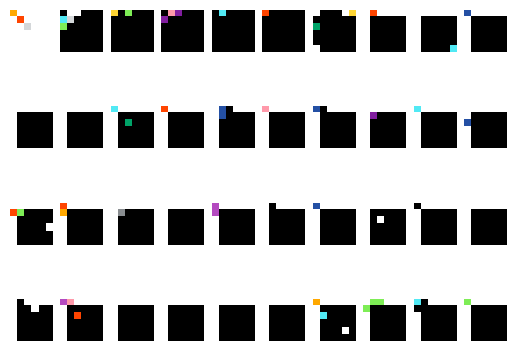

In [11]:
file_size_bmp_area, file_size_png_area, time_inds_list_area = rp.save_part_over_time(canvas_area,
                                                                      time_interval, # in seconds
                                                                      total_time=total_time, # in seconds
                                                                      part_name = 'area', # only for name of output
                                                                      delete_bmp = True, 
                                                                      show_plot = True)

### Plot the compressed file size ratio over time

Next, we'll perform calculations to further analyze the CanvasPart objects. We can use the compressed file size as a way to characterize the 'complexity' of a part of the canvas. We'll plot the ratio of the compressed file size to the original file size for both the canvas composition and the canvas area

##### Save the frames as a movie

In [12]:
image_path = os.path.join(os.getcwd(), 'figs', 'history_comp')

Save frames as a movie

In [13]:
rp.save_movie(image_path, 
              movie_tool='moviepy',
              fps=1,
              codec='libx264',
              video_type='mp4')

Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/figs/history_comp/canvaspart_time000000_fps1.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/figs/history_comp/canvaspart_time000000_fps1.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/figs/history_comp/canvaspart_time000000_fps1.mp4


#### Saving and loading the timestep data

In [14]:
rp.save_canvas_part_time_steps(canvas_comp,  
                               time_inds_list_comp,
                               time_interval,
                               file_size_bmp,
                               file_size_png)

In [15]:
(canvas_comp, 
 time_inds_list_comp,
 time_interval,
 file_size_bmp,
 file_size_png) = rp.load_canvas_part_time_steps()

#### Calculate number of pixel changes and touched pixels for thermodynamic quantities


In [16]:
(num_pixel_changes, 
 num_touched_pixels,
 num_users) =  th.calc_num_pixel_changes(canvas_comp,
                                         time_inds_list_comp,
                                         time_interval)

##### Plot

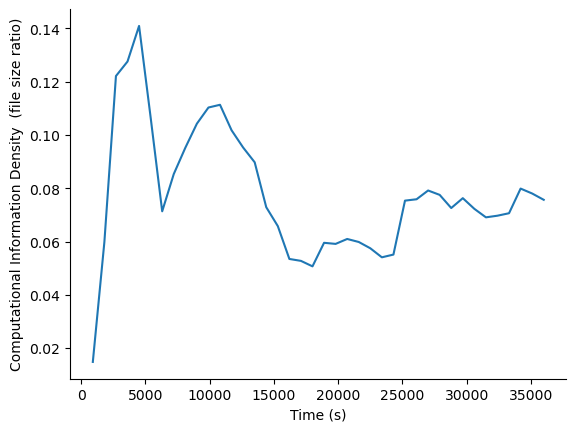

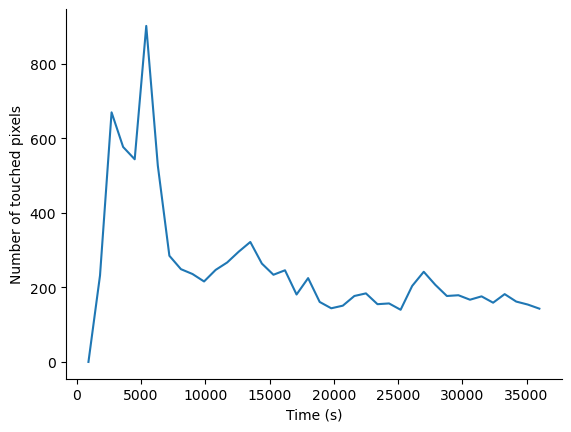

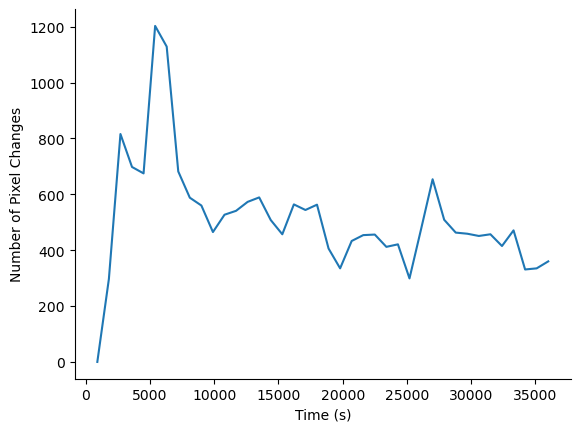

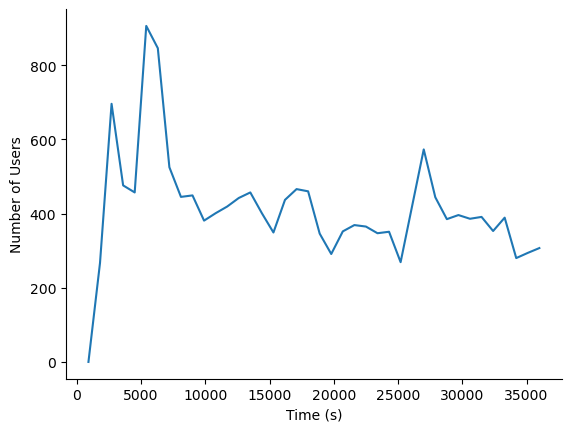

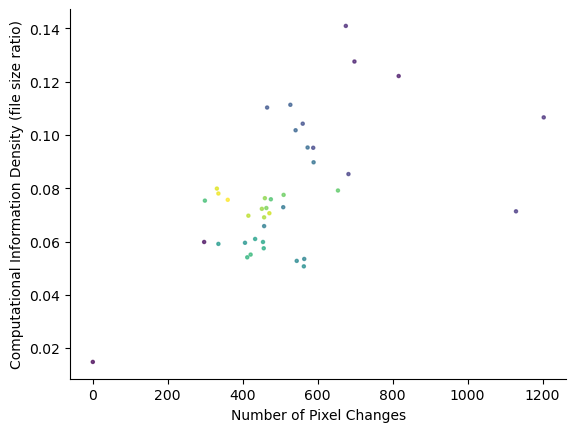

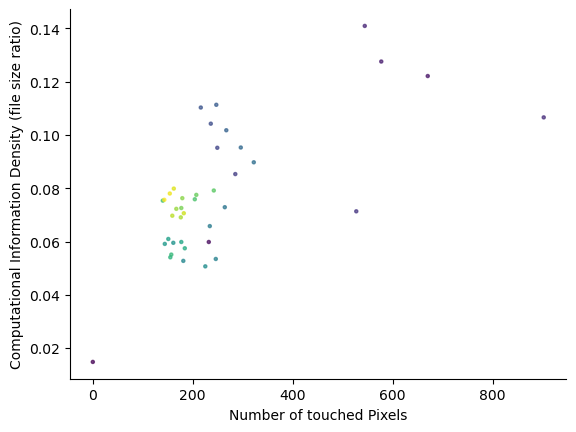

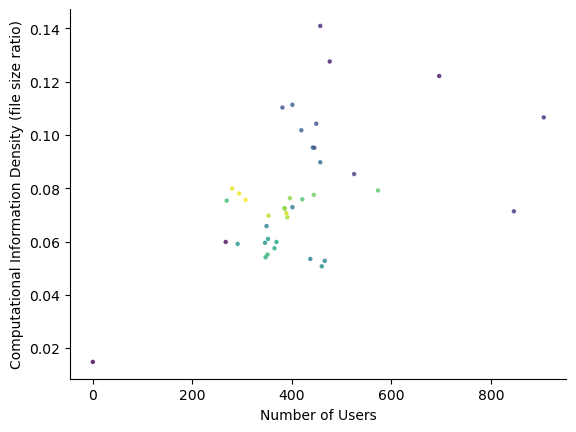

In [17]:
(fig_cid_vs_time, 
fig_num_touched_pix_vs_time, 
fig_num_pix_changes_vs_time, 
fig_users_vs_time,
fig_cid_vs_num_pix_changes,
fig_cid_vs_num_touched_pix,
fig_cid_vs_num_users)= th.plot_compression_vs_pixel_changes(num_pixel_changes, 
                                                            num_touched_pixels, 
                                                            num_users,
                                                            time_interval,
                                                            file_size_png, 
                                                            file_size_bmp)

manipulate the plots

(0.0, 5000.0)

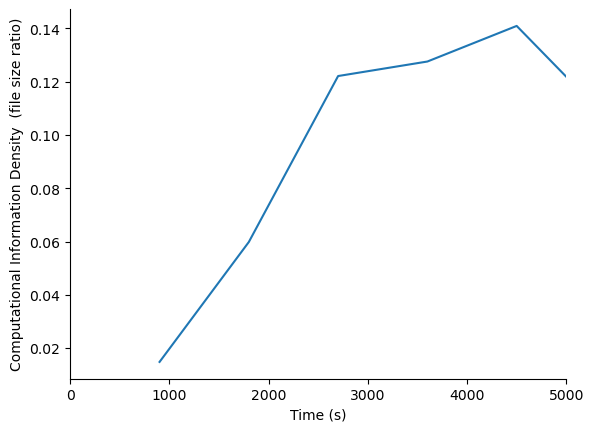

In [18]:
plt.figure()
plt.sca(fig_cid_vs_time.gca())
plt.xlim([0,5000])